# Model Diagnostics

The purpose of this assigment is introduce you to a new library for linear regression called statmodels which is much better suited for inferential modeling than sklearn. This assignment is also to familiarize yourself with some of most important procedures for improving the interpretability of regression coefficients. You will also perform important statistical tests that will help establish that whether or not important assumptions that safeguard the interpretability of OLS coefficients have been met. 

We will continue to use the Ames Housing Dataset so that you can focus on the techniques and not on cleaning/getting associated with a brand new dataset.

In [1]:
!pip3 uninstall seaborn

Uninstalling seaborn-0.7.1:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/seaborn-0.7.1-py3.6.egg-info
    /usr/local/lib/python3.6/dist-packages/seaborn/*
Proceed (y/n)? y
  Successfully uninstalled seaborn-0.7.1


In [1]:
# restart runtime after running cell
!pip3 --no-cache-dir install seaborn

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/ryanleeallred/datasets/master/Ames%20Housing%20Data/train.csv')
df = df.drop(['Id'], axis=1)
df = df.fillna(0)

def clean_cat(df):
  for col_name in df.columns:
      if(df[col_name].dtype == 'object'):
          df[col_name]= df[col_name].astype('category')
          df[col_name] = df[col_name].cat.codes
          



clean_cat(df)

## 1.1 Choose an X and Y variable from your dataset and use them to create a Seaborn Regplot

In [27]:
pd.set_option('display.max_columns', 100)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,3,65.0,8450,1,0,3,3,0,4,0,5,2,2,0,5,7,5,2003,2003,1,1,12,13,2,196.0,2,4,2,3,4,4,3,706,6,0,150,856,1,0,1,5,856,854,0,1710,1,0,2,1,3,1,2,8,6,0,0,2,2003.0,2,2,548,5,5,2,0,61,0,0,0,0,0,0,0,0,2,2008,8,4,208500
1,20,3,80.0,9600,1,0,3,3,0,2,0,24,1,2,0,2,6,8,1976,1976,1,1,8,8,3,0.0,3,4,1,3,4,2,1,978,6,0,284,1262,1,0,1,5,1262,0,0,1262,0,1,2,0,3,1,3,6,6,1,5,2,1976.0,2,2,460,5,5,2,298,0,0,0,0,0,0,0,0,0,5,2007,8,4,181500
2,60,3,68.0,11250,1,0,0,3,0,4,0,5,2,2,0,5,7,5,2001,2002,1,1,12,13,2,162.0,2,4,2,3,4,3,3,486,6,0,434,920,1,0,1,5,920,866,0,1786,1,0,2,1,3,1,2,6,6,1,5,2,2001.0,2,2,608,5,5,2,0,42,0,0,0,0,0,0,0,0,9,2008,8,4,223500
3,70,3,60.0,9550,1,0,0,3,0,0,0,6,2,2,0,5,7,5,1915,1970,1,1,13,15,3,0.0,3,4,0,4,2,4,1,216,6,0,540,756,1,2,1,5,961,756,0,1717,1,0,1,0,3,1,2,7,6,1,3,6,1998.0,3,3,642,5,5,2,0,35,272,0,0,0,0,0,0,0,2,2006,8,0,140000
4,60,3,84.0,14260,1,0,0,3,0,2,0,15,2,2,0,5,8,5,2000,2000,1,1,12,13,2,350.0,2,4,2,3,4,1,3,655,6,0,490,1145,1,0,1,5,1145,1053,0,2198,1,0,2,1,4,1,2,9,6,1,5,2,2000.0,2,3,836,5,5,2,192,84,0,0,0,0,0,0,0,0,12,2008,8,4,250000


In [0]:
df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
df['log_price'] = np.log(df['SalePrice'])
features_target = df.filter(['GrLivArea', 'YearBuilt', 'YearRemodAdd', 
                             'TotalBsmtSF', 'OverallQual', 'log_price'])

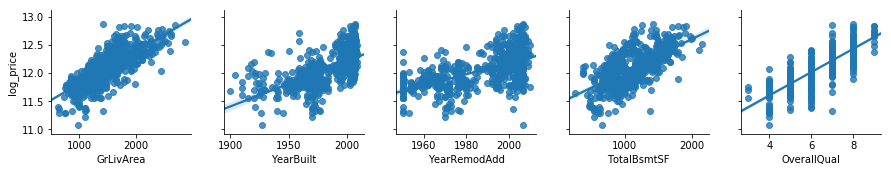

In [29]:
sns.pairplot(features_target, x_vars=['GrLivArea', 'YearBuilt', 'YearRemodAdd', 
                             'TotalBsmtSF', 'OverallQual'], y_vars=['log_price'],
            kind='reg');

## 1.2 Now using the X variables that you feel like will be the best predictors of y use statsmodel to run the multiple regression between these variables and Y. You don't need to use every X variable in your dataset, in fact it's probably better if you don't. Just pick ones that you have already cleaned that seem the most relevant to house prices.

In [0]:
X = features_target.drop(['log_price'], axis=1)
y = df['log_price']

In [31]:
# add columns of 1

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
predictions = model.predict(X)

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     697.6
Date:                Thu, 17 Jan 2019   Prob (F-statistic):          4.29e-246
Time:                        22:17:29   Log-Likelihood:                 425.08
No. Observations:                 601   AIC:                            -838.2
Df Residuals:                     595   BIC:                            -811.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            4.0942      0.678      6.037   

## 1.3 Identify the standard errors and P-Values of these coefficients in the output table. What is the interpretation of the P-values here?

In [35]:
print('Standard Error for features\n\n', model.bse)

Standard Error for features

 const           0.678181
GrLivArea       0.000015
YearBuilt       0.000323
YearRemodAdd    0.000393
TotalBsmtSF     0.000017
OverallQual     0.006900
dtype: float64


# Understanding the P-value

The p-value is an indicator with a threshold.
If the p-value is less than the threshold, we reject the null hypothesis given our data, if it is above the threshold, the features or data we're analyszing have no significance to the prediction of the targets, or y.

Our threshold is that p < 0.05 is a rejection of the null hypothesis. 


Every single one of our values below has a p-value well under the threshold, so we reject the null hypothesis for all of them. 

A less freaking roundabout way of saying that is 'All the selected features are significant to our target log_price'

In [36]:
print('P-values for features\n\n',model.pvalues)

P-values for features

 const           2.763187e-09
GrLivArea       6.278050e-81
YearBuilt       1.642257e-06
YearRemodAdd    2.450582e-06
TotalBsmtSF     3.166772e-41
OverallQual     6.587049e-19
dtype: float64


## 1.4 Remove outliers from your dataset and run the regression again. Do you see a change in some coefficients? Which seem to move the most?

In [37]:
print('Sorry, already did that :/')

Sorry, already did that :/


## 1.5 Create a new log(y) variable and use it to run a log-linear regression of your variables using statmodels 

In [38]:
print('Oops, sorry, i did that too :/')

Oops, sorry, i did that too :/


## 2.1 Run a test for high levels of collinearity in your dataset. Calculate the Variance Inflation Factor for each X variable. Do you see VIF values greater than ten? If so try omitting those X variables and run your regression again. Do the standard errors change? Do the coefficients change? Do the coefficients seem to have an interpretation that matches your intuition?

In [48]:
variance_i_f = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(variance_i_f)

[19232.166436664043, 1.6969475932203801, 2.5126665855053214, 2.109240487726108, 1.3448308608808421, 2.9641613528417543]


In [0]:
X = X.drop('const', axis=1)

In [50]:
model = sm.OLS(y, X).fit()
predictions = model.predict(X)

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.152e+06
Date:                Thu, 17 Jan 2019   Prob (F-statistic):               0.00
Time:                        22:49:21   Log-Likelihood:                 407.22
No. Observations:                 601   AIC:                            -804.4
Df Residuals:                     596   BIC:                            -782.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
GrLivArea        0.0003   1.55e-05     22.332   

## 2.2 Variables that have high levels of multicollinearity should also be highly correlated with each other. Calculate your X matrix's correlation matrix to check if the variables highlighted by the VIF test truly are highly correlated.

# A note on detecting collinearity

You can detect high-multi-collinearity by inspecting the eigen values of correlation matrix. A very low eigen value shows that the data is collinear, and the corresponding eigen vector shows which variables are collinear.

If there is no collinearity in the data, you would expect that none of the eigen values are close to zero:

In [51]:
corr = np.corrcoef(X, rowvar=0)

eigenvalues, eigenvectors = np.linalg.eig(corr)

eigenvalues

array([2.95080122, 0.82837086, 0.68672092, 0.23133232, 0.30277468])

# Close enough to explore

I feel like our 4th variable is close enough to take a look at, it's almost zero, sort of. I just want to try it okay!



In [45]:
eigenvectors[:,3]

array([ 0.37102761,  0.54503303, -0.15890756,  0.1110849 , -0.72642002])

# Corresponding eigenvectors not close to zero indicate collinearity 

Features[2, 5] seem to be collinear

In [0]:
##### Your Code Here #####

## 2.3 If you have varaibles with high Variance Inflation Factors, try excluding them from your regression. Do your standard errors improve? (get smaller). If high levels of multicollinearity are removed, the precision of the dataset should increase.

In [0]:
##### Your Code Here #####

## 2.4 Recalculate your regression using Robust Standard Errors? What happens to your standard errors?

In [0]:
##### Your Code Here #####

## 2.5 Use scatterplots or Seaborn's pairplot functionality to perform an eyeball test for potential variables that would be candidates for generating polynomial regressors. 

In [0]:
##### Your Code Here #####

## 2.6 Use seaborn's residplot to plot the distribution of each x variable's residuals. Does these plots indicate any other features that would be potential candidates for polynomial features.

In [0]:
##### Your Code Here #####

## 2.6 Feature Engineer the appropriate polynomial features from your analysis above and include them in one final log-polynomial, robust standard error, regression. Do the coefficients of this most advanced regression match your intuition better than the coefficients of the very first regression that we ran with the Statmodels library?

In [0]:
##### Your Code Here #####